# Solving the Clustering Problem Using QAOA on a MAXCUT Graph

## Motivation

The clustering problem is a classic problem in unsupervised machine learning for classifying points into clusters so that points in the same cluster are similar and points in different clusters are dissimilar, given some similarity metric. Clustering is an *unsupervised* method because it operates on data without labels: we simply try to cluster a given set of points about which we know nothing other than the similarity measure between every pair of points. In real-world machine learning applications, data labels are expensive. To clarify, a data label is just a ground truth label for a data point, eg. a label of "cat" for an image of a cat, or a label of "positive" for a positive movie review. These labels are very useful in supervised machine learning, where we train our model on labeled data by updating the weights we are learning, for every data point, according to how far we are from the true label.

While supervised machine learning has produced great results, unsupervised ML is also quite important. Its importance stems from the fact that, as mentioned earlier, getting labeled data is expensive (we usually need a human expert to do it), while raw data is available in copious amounts. The clustering problem is one example of an unsupervised learning problem, and it has had many successful real-world applications.

In this project, I demonstrate a simple clustering algorithm for a quantum/classical hybrid computer, inspired by this recent [paper](https://arxiv.org/abs/1712.05771) by researchers at Rigetti.

In [43]:
%env QVM_API_KEY=nmRPAVunQl19TtQz9eMd11iiIsArtUDTaEnsSV6u
%env QVM_USER_ID=5fd5fe79-f138-47c0-9f54-d9385a20f585

env: QVM_API_KEY=nmRPAVunQl19TtQz9eMd11iiIsArtUDTaEnsSV6u
env: QVM_USER_ID=5fd5fe79-f138-47c0-9f54-d9385a20f585


## Algorithm and Implementation

Instead of separating this project report into a section explaining the algorithm and a section showing the code with interactive results, I will do both at the same time, building up the code as I explain the algorithm.

As we learned in class, we can solve the MAXCUT problem by constructing a cost Hamiltonian whose ground state encodes the solution to the optimization problem. For an unweighted MAXCUT instance, we can think of the problem as a 2-coloring problem where we try to assign each node a color such that we minimize the number of pairs of adjacent nodes that have the same color. (This is not exactly 2-coloring since 2-coloring requires that no pair of adjacent nodes having the same color exist, but this is a relaxed version of it.) Intuitively, we are trying to maximize disagreement between adjacent nodes.

Let's try to solve MAXCUT on a simple graph. In the following, I'm adapting code from Rigetti's docs and source code.

First, we import the packages we need, then initialize an API connection. The print function being defined is just a technicality for usage in the variational quantum eigensolver code used by QAOA.

In [6]:
import numpy as np
import pyquil.api as api
from pyquil.paulis import PauliTerm, PauliSum
import networkx as nx
import math
from scipy.optimize import minimize
from qaoa import QAOA

CXN = api.QVMConnection()
def print_fun(x):
    print(x)

`numpy` is the popular scientific computing Python library, `pyquil.api` is the API to interact with PyQuil, `PauliTerm` and `PauliSum` are Pauli operator primitives implemented [here](https://github.com/rigetticomputing/pyquil/blob/master/pyquil/paulis.py), `networkx` is the package used for building Graph objects, the `minimize` module from SciPy is the optimizer used by the QAOA instance we will create, and finally we import the `QAOA` class, the core of this algorithm.

The following function is a slightly modified version of the `maxcut_qaoa` function implemented in the `grove` package [here](https://github.com/rigetticomputing/grove/blob/master/grove/pyqaoa/maxcut_qaoa.py). This version allows weighted MAXCUT graphs, which for some reason isn't implemented in the original source code.

In [7]:
def maxcut_qaoa(graph, steps=1, rand_seed=None, connection=None, samples=None,
                initial_beta=None, initial_gamma=None, minimizer_kwargs=None,
                vqe_option=None, weighted=False):
    """
    Max cut set up method

    :param graph: Graph definition. Either networkx or list of tuples
    :param steps: (Optional. Default=1) Trotterization order for the QAOA algorithm.
    :param rand_seed: (Optional. Default=None) random seed when beta and gamma angles
        are not provided.
    :param connection: (Optional) connection to the QVM. Default is None.
    :param samples: (Optional. Default=None) VQE option. Number of samples
        (circuit preparation and measurement) to use in operator averaging.
    :param initial_beta: (Optional. Default=None) Initial guess for beta parameters.
    :param initial_gamma: (Optional. Default=None) Initial guess for gamma parameters.
    :param minimizer_kwargs: (Optional. Default=None). Minimizer optional arguments.  If None set to
        ``{'method': 'Nelder-Mead', 'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2, 'disp': False}``
    :param vqe_option: (Optional. Default=None). VQE optional arguments.  If None set to
        ``vqe_option = {'disp': print_fun, 'return_all': True, 'samples': samples}``

    """
    if not isinstance(graph, nx.Graph) and isinstance(graph, list):
        maxcut_graph = nx.Graph()
        for edge in graph:
            maxcut_graph.add_edge(*edge)
        graph = maxcut_graph.copy()

    cost_operators = []
    driver_operators = []
    for i, j in graph.edges():
        if weighted:
            cost_operators.append(PauliTerm("Z", i, 0.5 * graph[i][j]['weight']) * PauliTerm("Z", j) + \
                                  PauliTerm("I", 0, -0.5 * graph[i][j]['weight']))
        else:
            cost_operators.append(PauliTerm("Z", i, 0.5)*PauliTerm("Z", j) + PauliTerm("I", 0, -0.5))
    for i in graph.nodes():
        driver_operators.append(PauliSum([PauliTerm("X", i, -1.0)]))

    if connection is None:
        connection = CXN

    if minimizer_kwargs is None:
        minimizer_kwargs = {'method': 'Nelder-Mead',
                            'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2,
                                        'disp': False}}
    if vqe_option is None:
        vqe_option = {'disp': print_fun, 'return_all': True,
                      'samples': samples}

    qaoa_inst = QAOA(connection, list(graph.nodes()), steps=steps, cost_ham=cost_operators,
                     ref_ham=driver_operators, store_basis=True,
                     rand_seed=rand_seed,
                     init_betas=initial_beta,
                     init_gammas=initial_gamma,
                     minimizer=minimize,
                     minimizer_kwargs=minimizer_kwargs,
                     vqe_options=vqe_option)

    return qaoa_inst

The main argument to this function is the `graph`, which is either a list of tuples each representing a pair of adjacent nodes, or a networkx graph. If the former option is used, a networkx graph is still constructed anyway out of the given list of edges, as seen in the first `if` block.

After that, we create two lists for the cost Hamiltonian and the driver Hamiltonian. As explained in lecture and [here](http://grove-docs.readthedocs.io/en/latest/qaoa.html), the cost Hamiltonian is designed so that its ground state encodes the solution to the MAXCUT problem. Note that here, there is a minus sign added to the Hamiltonian expression so that the maximum weight cut, which is the solution to the problem, minimizes the expression (instead of maximizing it) so that the ground state encodes the solution. I added a `weighted` argument to the function, defaulting to `False`. When set to `True`, I multiply the coefficients of the Pauli operator product term and the identity matrix term by the corresponding weight. The first argument to the `PauliTerm` constructor is the type of operator, the second is the index of the qubit, and the third is the coefficient. More info can be found [here](https://github.com/rigetticomputing/pyquil/blob/master/pyquil/paulis.py).

The driver (or reference) Hamiltonian is the sum of Pauli-X operators on all the qubits. We use the `PauliSum` constructor on the single `PauliTerm` object because the operators need to be of type `PauliSum`. In the case of the cost operators, we didn't need to do this because adding two `PauliTerm`'s automatically creates a `PauliSum` object. Note that the cost and driver Hamiltonians are each represented as a list of clauses, where each clause is one term in the summation.

We then create an instance of the QAOA class, giving it the relevant arguments, and return that instance to be used by the client. Now let's use this function! We start with a very simple graph, the 0-1-2 graph which is a chain of three nodes 0, 1, and 2. This means we have edges (0, 1) and (1, 2). We can run `maxcut_qaoa` on this simple, unweighted graph as follows. This example is taken from the source code.

In [12]:
inst = maxcut_qaoa([(0, 1), (1, 2)], steps=2, rand_seed=42, samples=None)
betas, gammas = inst.get_angles()
most_freq_str, sampling_results = inst.get_string(betas, gammas)
print most_freq_str

                     models will be ineffective
	Parameters: [3.13609493 1.17665249 4.59925358 3.76148219] 
	E => -2.6573859813
	Parameters: [3.13609493 1.17665249 4.59925358 3.76148219] 
	E => -2.74633542148
	Parameters: [3.23876471 1.11414282 4.9873156  3.7262183 ] 
	E => -3.25998098002
	Parameters: [3.23876471 1.11414282 4.9873156  3.7262183 ] 
	E => -3.2514807001
	Parameters: [3.23876471 1.11414282 4.9873156  3.7262183 ] 
	E => -3.18909749201
	Parameters: [3.38693586 1.0861054  4.78430167 3.76295152] 
	E => -3.55507934313
	Parameters: [3.38693586 1.0861054  4.78430167 3.76295152] 
	E => -3.36400762203
	Parameters: [3.38693586 1.0861054  4.78430167 3.76295152] 
	E => -3.45307362101
	Parameters: [3.38693586 1.0861054  4.78430167 3.76295152] 
	E => -3.4446919406
	Parameters: [3.38693586 1.0861054  4.78430167 3.76295152] 
	E => -3.45621367591
	Parameters: [3.42271168 1.02290988 4.87779419 3.96483503] 
	E => -3.53009542359
	Parameters: [3.42271168 1.02290988 4.87779419 3.96483503] 
	E =

As we can see, we get one of the two optimal solutions; the bit string here corresponds to a coloring of the graph where 0 can represent white and 1 black. We can see the variational quantum eigensolver (VQE) algorithm converging to the optimal energy value of the system, corresponding to the maximum weight cut. Here it's -2 corresponding to two disagreeing pairs: the (0, 1) pair and the (1, 2) pair.

We can also get the wavefunction of the system and plot the probability amplitudes of all the bit strings (basis states), as follows.

[3.53660186 0.78015385 4.70860242 3.92877785]


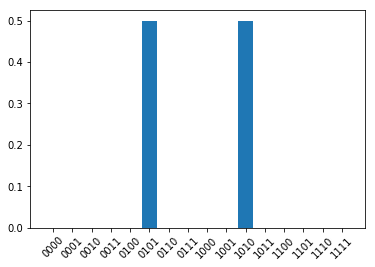

In [13]:
import matplotlib.pyplot as plt

t = np.hstack((betas, gammas))
print t
param_prog = inst.get_parameterized_program()
prog = param_prog(t)
wf = CXN.wavefunction(prog)
wf = wf.amplitudes

n_qubits = 3 # 3 qubits for the 0-1-2 graph
x = range(2 ** n_qubits)
xticks = [] # x axis labels
y = []

for state_index in x:
	xticks.append(inst.states[state_index])
	y.append(np.real(np.conj(wf[state_index]) * wf[state_index])) # magnitude squared => probability amplitude

plt.xticks(x, xticks, rotation=45)
plt.bar(x, y)
plt.show()

We can see that we converge to the two optimal solutions.

We can also try this for other simple graphs, such as a square ring, which is the example used in the QAOA docs. To do this we can simply change the input list of tuples to be `[(0, 1), (1, 2), (2, 3), (3, 0)]` and making `n_qubits = 4`. Feel free to try that out yourself by modifying the code above.

Now we want to transition to weighted graphs. If we can solve these in the same way, we can solve the clustering problem by transforming it into a MAXCUT instance on a fully connected graph where each pair of nodes is connected by an edge whose weight is the distance between the two points the nodes represent. Let's change our simple example to be a weighted graph. Specifically, let's make node 0 far away from nodes 1 and 2 (say, at a distance of 50.0 from node 1), with 1 and 2 being close to each other (at distance 1.0 from each other). Visually, this is like having the same 0-1-2 chain shape but with the link between 0 and 1 being much longer. We construct this with a networkx graph, as follows.

In [14]:
g = nx.Graph()
g.add_edges_from([(0, 1, {'weight': 50.0}), (1, 2, {'weight': 1.0}), (0, 2, {'weight': 51.0})])

Note that in this case we want to have an edge between *every* pair of nodes, so we add a new edge from 0 to 2 with weight 51, corresponding to the total distance between them. Next, we go through the same steps as before, this time setting `weighted = True` for the `maxcut_qaoa` instance.

In [27]:
inst = maxcut_qaoa(g, steps=3, weighted=True)
betas, gammas = inst.get_angles()
most_freq_str, sampling_results = inst.get_string(betas, gammas)
print most_freq_str

                     models will be ineffective
	Parameters: [0.96095976 2.60314655 3.04626259 0.61624904 4.31707608 2.77708285] 
	E => -55.9643639844
	Parameters: [0.96129205 2.54494612 3.04731594 0.61646213 4.31856884 2.77804311] 
	E => -57.0271494839
	Parameters: [0.98158894 2.54538703 3.04845706 0.61669297 4.320186   2.7790834 ] 
	E => -58.314805234
	Parameters: [0.95971601 2.54586469 3.11289374 0.61694306 4.32193793 2.78021037] 
	E => -60.9330709405
	Parameters: [0.95971601 2.54586469 3.11289374 0.61694306 4.32193793 2.78021037] 
	E => -56.8675301033
	Parameters: [0.95983033 2.54612342 3.07827642 0.61707852 4.32288689 2.80962873] 
	E => -52.6629742814
	Parameters: [0.95983033 2.54612342 3.07827642 0.61707852 4.32288689 2.80962873] 
	E => -54.2036012577
	Parameters: [0.96150223 2.54990734 3.08392202 0.61330627 4.33676542 2.79911115] 
	E => -29.9256559054
	Parameters: [0.96066628 2.54801538 3.08109922 0.61519239 4.32982616 2.80436994] 
	E => -50.1925036173
	Parameters: [0.96066628 2

	Parameters: [0.9818408  2.63927274 2.75168084 0.61811296 4.32289352 2.8112183 ] 
	E => -94.6861275743
	Parameters: [0.9818408  2.63927274 2.75168084 0.61811296 4.32289352 2.8112183 ] 
	E => -94.6639246547
	Parameters: [0.9818408  2.63927274 2.75168084 0.61811296 4.32289352 2.8112183 ] 
	E => -94.6683119896
	Parameters: [0.98018249 2.63648974 2.76813521 0.61810421 4.32420488 2.81095055] 
	E => -94.686478552
	Parameters: [0.98138835 2.63182333 2.77662513 0.61720487 4.32370395 2.81092546] 
	E => -94.7689347139
	Parameters: [0.98138835 2.63182333 2.77662513 0.61720487 4.32370395 2.81092546] 
	E => -94.7077305529
	Parameters: [0.98138835 2.63182333 2.77662513 0.61720487 4.32370395 2.81092546] 
	E => -94.7146303288
	Parameters: [0.9823234  2.63849006 2.75220307 0.61767011 4.32299353 2.81139081] 
	E => -94.7565895879
	Parameters: [0.9823234  2.63849006 2.75220307 0.61767011 4.32299353 2.81139081] 
	E => -94.7585879877
	Parameters: [0.9823234  2.63849006 2.75220307 0.61767011 4.32299353 2.811

We should find that we get one of the two optimal bit strings `011` and `100`, which is a successful clustering of these three points so that the far away point represented by node 0 is in one group (0) and the two others are in another group (1). Notice that the expectation value computed during the VQE run approaches the optimal value -101. In some runs I did, it didn't get as close to -101 as in other runs. Let's plot the probability amplitudes.

[0.98793595 2.63127847 2.75155719 0.61465586 4.321604   2.81226287]


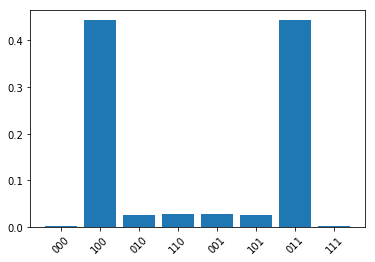

In [28]:
t = np.hstack((betas, gammas))
print t
param_prog = inst.get_parameterized_program()
prog = param_prog(t)
wf = CXN.wavefunction(prog)
wf = wf.amplitudes

n_qubits = 3 # 3 qubits for the 0-1-2 graph
x = range(2 ** n_qubits)
xticks = [] # x axis labels
y = []

for state_index in x:
    # I added [::-1] to reverse the string since here its direction is opposite to the visual direction we're
    # considering, so it would show 001 in place of 100. 
	xticks.append(inst.states[state_index][::-1])
	y.append(np.real(np.conj(wf[state_index]) * wf[state_index])) # magnitude squared => probability amplitude

plt.xticks(x, xticks, rotation=45)
plt.bar(x, y)
plt.show()

We can experiment with different step counts to see how much better the algorithm does with more steps (i.e. more iterations in which we apply the pair of unitary transformations), as well as what number of steps is necessary to get the algorithm to deterministically return one of the two optimal solutions. To experiment, we can just change the `steps` argument in this line `inst = maxcut_qaoa(g, steps=2, weighted=True)`, then rerun that block of code and the next code block that visualizes the amplitudes.

In my experiments, 1 step produced a probability distribution that was still concentrated around the two solutions (and the most frequent bit string was indeed one of the two solutions), but other bit strings had a significant probability of appearing as well. With 2 steps, the probability of a non-optimal bit string appearing became significantly smaller, sometimes going to 0 if the VQE run was lucky, but was still there in general. The same was true of 3 steps. In the one run I did with 4 steps, the probabilites were purely concentrated at 100 and 011 (0.5 for each), which is the ideal result.

## Clustering: classical k-means vs. quantum

Now I set up a small example that serves as a realistic example of a clustering problem instance, solve it using the classic (as in old and well studied), classical (as in non-quantum) algorithm k-means, and then solve it using the quantum method developed above. I choose a set of 10 points that are easy to cluster, with 5 points roughly in the bottom left and 5 points roughly in the top right. The first step of k-means is to randomly select a number of centers. After doing that, I plot all the points, with red points being the input data points and green points being the two centers (there are 2 centers because we want to cluster the points into only 2 clusters in this example).

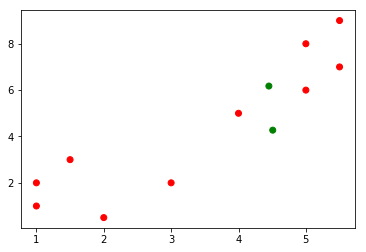

In [30]:
import random

points = [(1,1),
		  (1,2),
		  (1.5,3),
		  (2,0.5),
		  (3,2),
		  (4,5),
		  (5,6),
		  (5.5,7),
		  (5,8),
		  (5.5,9)]

centers = [(random.uniform(1.0, 5.5), random.uniform(0.5, 9.0)),
		   (random.uniform(1.0, 5.5), random.uniform(0.5, 9.0))]

x, y = list(zip(*points)[0]), list(zip(*points)[1])

colors = ['red'] * len(x)

for center in centers:
	x.append(center[0])
	y.append(center[1])
	colors.append('green')

plt.scatter(x, y, color=colors)
plt.show()

The following is my code for k-means, which is not very well designed but does the trick for our purposes. This line `new_centers, new_assignments = kmeans_iteration(points, centers)` runs our first iteration of k-means, which assigns each point to a *cluster* defined by one of the two centers. I then plot all the points, this time coloring points assigned to the first cluster red and ones assigned to the second cluster blue. Each iteration of k-means involves two steps: 1) assigning each point to the closest center to it, and 2) updating each center to be the average of all points assigned to it. So the two green centers are now updated as well.

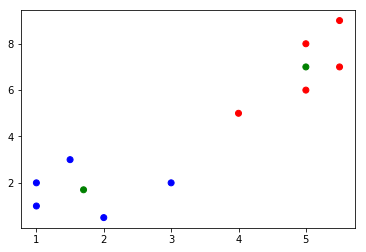

In [32]:
def euclidean_dist(x, y):
	return math.sqrt(abs(x[0] - y[0]) ** 2 + abs(x[1] - y[1]) ** 2)

def get_closest_center(point, centers):
	min_dist = float('inf')
	closest = None
	for center in centers:
		dist = euclidean_dist(point, center)
		if dist < min_dist:
			min_dist = dist
			closest = center
	return closest

def average(points):
	avg_x = sum(p[0] for p in points) / len(points)
	avg_y = sum(p[1] for p in points) / len(points)
	return (avg_x, avg_y)

def kmeans_iteration(points, centers):
	new_assignments = {}
	for point in points:
		closest = get_closest_center(point, centers)
		new_assignments[point] = centers.index(closest)
	new_centers = []
	for center in centers:
		assigned_points = [point for point in points if new_assignments[point] == centers.index(center)]
		avg = average(assigned_points)
		new_centers.append(avg)
	return new_centers, new_assignments

new_centers, new_assignments = kmeans_iteration(points, centers)

x, y = list(zip(*points)[0]), list(zip(*points)[1])

colors = []
for point in points:
	if new_assignments[point] == 0:
		colors.append('red')
	elif new_assignments[point] == 1:
		colors.append('blue')
	else:
		print 'error'

for center in new_centers:
	x.append(center[0])
	y.append(center[1])
	colors.append('green')

plt.scatter(x, y, color=colors)
plt.show()


In most cases, we will find that the points are all successfully clustered after the first iteration since this set of points is easy to cluster. But if the two random initial centers weren't positioned favorably, we might need a few more iterations. In this case, we can add this line `new_centers, new_assignments = kmeans_iteration(points, new_centers)` after the first k-means iteration to run one more iteration, and we can keep adding the same line for more iterations until the clustering is complete.

Now let's cluster these points quantumly! First, we need to transform the problem into a graph MAXCUT problem. To do this, we simply construct a networkx graph where the nodes represent the points and each pair of nodes is connected by an edge whose weight is the distance of the corresponding points. We define a function to do this below.

In [38]:
def get_maxcut_graph(points):
    g = nx.Graph()
    g.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        for j in range(len(points)):
            if i != j:
                g.add_edge(i, j, weight=euclidean_dist(points[i], points[j]))
    return g

g = get_maxcut_graph(points)

Now we can run QAOA on `g` and see what we get. This is an example of the power we can get from transforming a problem into another representation that we can readily tackle using tools we already have. 

In [39]:
inst = maxcut_qaoa(g, steps=2, weighted=True)
betas, gammas = inst.get_angles()
most_freq_str, sampling_results = inst.get_string(betas, gammas)
print most_freq_str

                     models will be ineffective
	Parameters: [1.59453525 0.39297928 0.22147119 5.42775716] 
	E => -97.9981024083
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.2937611655
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.2079380441
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -98.7295401486
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.0527451048
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -98.8734182063
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.1716411611
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.2211783441
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.2329288682
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.2591788448
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	E => -99.2445834889
	Parameters: [1.64314913 0.35224363 0.22822336 5.49917502] 
	

	Parameters: [1.74123068 0.51090063 0.34874454 5.32914112] 
	E => -100.262225344
	Parameters: [1.73728854 0.4061114  0.34178559 5.33088644] 
	E => -100.405282228
	Parameters: [1.73728854 0.4061114  0.34178559 5.33088644] 
	E => -100.305422134
	Parameters: [1.73728854 0.4061114  0.34178559 5.33088644] 
	E => -100.31324116
	Parameters: [1.76927021 0.29395174 0.36423267 5.31135317] 
	E => -100.490765276
	Parameters: [1.76927021 0.29395174 0.36423267 5.31135317] 
	E => -100.452129784
	Parameters: [1.77733516 0.04057454 0.36811525 5.31690394] 
	E => -100.778409932
	Parameters: [ 1.79286897 -0.10267627  0.35489257  5.3215185 ] 
	E => -101.245764371
	Parameters: [ 1.79286897 -0.10267627  0.35489257  5.3215185 ] 
	E => -100.7913536
	Parameters: [ 1.82285745 -0.28132338  0.37473036  5.3171242 ] 
	E => -100.493771778
	Parameters: [ 1.82285745 -0.28132338  0.37473036  5.3171242 ] 
	E => -101.15773789
	Parameters: [ 1.82285745 -0.28132338  0.37473036  5.3171242 ] 
	E => -100.939340778
	Parameters:

In the below code, I omit the `xticks` lines because there are too many basis states (bit strings), so it's impossible to display all the x-axis labels -- the bit strings -- clearly. Instead, I just plot the probability amptliudes of all the bit strings. The x-axis values are meaningless and should be ignored. The purpose of this plot is just to get an idea on what the probability distribution looks like, to get insight into how well the algorithm is doing. If one bit string has very high probability, and that bit string, which is expected to be `most_freq_str` bit string, is a good (or perfect) result, the algorithm is doing well; the bigger the probabilities of *other* bit strings are, the worse it's doing. As long as the most frequent string is correct, though, this is a great result. More steps can yield a better probability distribution.

[2.20733143 0.09129012 0.35455007 5.50312937]


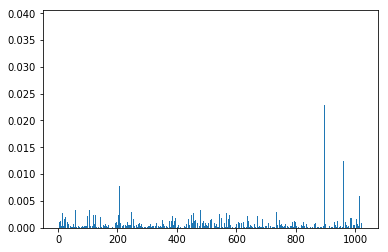

In [42]:
t = np.hstack((betas, gammas))
print t
param_prog = inst.get_parameterized_program()
prog = param_prog(t)
wf = CXN.wavefunction(prog)
wf = wf.amplitudes

n_qubits = 10 # 10 qubits for 10 points
x = range(2 ** n_qubits)
# xticks = [] # x axis labels
y = []

for state_index in x:
    # I added [::-1] to reverse the string since here its direction is opposite to the visual direction we're
    # considering, so it would show 001 in place of 100. 
	# xticks.append(inst.states[state_index][::-1])
	y.append(np.real(np.conj(wf[state_index]) * wf[state_index])) # magnitude squared => probability amplitude

# plt.xticks(x, xticks, rotation=45)
plt.bar(x, y)
plt.show()

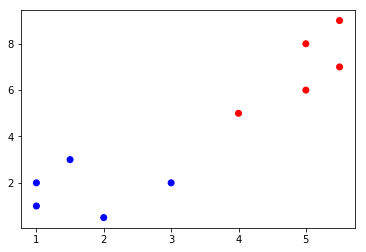

In [40]:
x, y = list(zip(*points)[0]), list(zip(*points)[1])
colors = []
for bit in most_freq_str:
    if bit == 0:
        colors.append('red')
    else:
        colors.append('blue')
        
plt.scatter(x, y, color=colors)
plt.show()

In my first run, I got `(1, 1, 1, 1, 1, 0, 0, 0, 0, 0)` as the most frequent bit string, which is the perfect result! The above code visualizes the clustering by coloring points assigned 1 in the bit string blue, and points assigned 0 in the bit string red.

This concludes my project! I've shown a proof-of-concept clustering algorithm using QAOA on a MAXCUT instance. Next steps include:

1. Understand why the Rigetti researchers used Bayesian optimization instead of VQE to choose the optimal rotation angles at each iteration, and implement it here and compare it with VQE.
2. Explore how many gates are needed for a `maxcut_qaoa` run (gates needed for the unitary transformations, complexities related to qubit connectivity, etc.), and how this algorithm scales in terms of circuit complexity.
3. Implement this algorithm on other quantum computing platforms (IBM, Microsoft), if possible, and analyze results.
4. Run this algorithm on a real quantum processor at Rigetti by applying for access, and gain some understanding of the physical setup and the physical challenges involved.